In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression

#original dataset source: https://archive.ics.uci.edu/ml/datasets/parkinsons
#load data for parkinsons disease
#estimated 1 million people in us/10 million in world with parkinsons
#http://www.parkinsonassociation.org/facts-about-parkinsons-disease/
raw = pd.read_csv("/Users/andrewperley/Desktop/School/PBMED/PBMED209/Final Project/parkinsonsdata.csv", delimiter=",")

with open("/Users/andrewperley/Desktop/School/PBMED/PBMED209/Final Project/parkinsonsdata.csv") as f:
    reader = csv.reader(f)
    rownum = 0;
    for row in reader:
        if rownum ==0:
            feature_names = row[1:25]
            rownum+=1;

data = np.loadtxt("/Users/andrewperley/Desktop/School/PBMED/PBMED209/Final Project/parkinsonsdata_num.csv", delimiter=",")

#get rid of 'status' as it is the name for the disease state
del(feature_names[16])

In [4]:
#column 16 is the disease label (1 for having parkinsons 0 for not)
#22 features total, 23 columns in data for features + labels
#195 observations total
#31 patients (about 6-7 observations each)
#extract features and labels separately
features = np.concatenate((np.array(data[:,0:16]),np.array(data[:,17:24])),axis = 1)
disease_state = np.array(data[:,16]);
pd.DataFrame(raw);

scaler = MinMaxScaler(copy=True, feature_range=(-1, 1));
features_sc = scaler.fit(features);
features = scaler.transform(features);

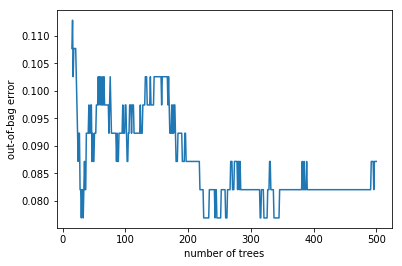

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#define random seed
RANDOM_STATE = 347;
oobError = []

clf = RandomForestClassifier( oob_score=True,random_state = RANDOM_STATE);
gbc = GradientBoostingClassifier();
ada = AdaBoostClassifier();
#look at OOB error for classifier to determine number of trees to use
for n_est in range(15,501):
    clf.set_params(n_estimators = n_est);
    clf.fit(features,disease_state)
    oob_error = 1 - clf.oob_score_
    oobError.append(oob_error);

plt.plot(range(15,501),oobError)
plt.xlabel('number of trees')
plt.ylabel('out-of-bag error')
plt.savefig('oobError.png')
#choose 225 trees since OOB error plateaus and is about lowest there for smallest number of trees
#try to avoid too much overfitting


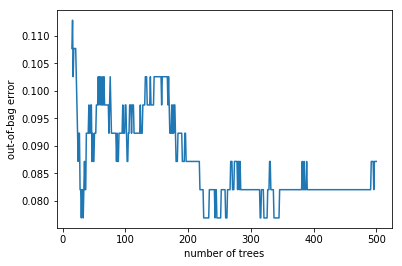

In [6]:
from sklearn.ensemble import RandomForestClassifier


#define random seed
RANDOM_STATE = 347;
oobError = []

clf = RandomForestClassifier( oob_score=True,random_state = RANDOM_STATE);

#look at OOB error for classifier to determine number of trees to use
for n_est in range(15,501):
    clf.set_params(n_estimators = n_est);
    clf.fit(features,disease_state)
    oob_error = 1 - clf.oob_score_
    oobError.append(oob_error);

plt.plot(range(15,501),oobError)
plt.xlabel('number of trees')
plt.ylabel('out-of-bag error')
plt.savefig('oobError.png')
#choose 225 trees since OOB error plateaus and is about lowest there for smallest number of trees
#try to avoid too much overfitting


In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
    
n_est = 225;
#focus on max depth and learning rate as hyperparameters to tune (regularization)

models = [RandomForestClassifier(n_estimators=n_est,max_depth=3),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_est),
          GradientBoostingClassifier(n_estimators=n_est,max_depth = 3)];
param_grid_rf = {
    "max_depth":[1,2,3,5,10],
    "max_features":[1,2,3,4,5,6,7]
}

param_grid_ada = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1),
                      DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3),
                      DecisionTreeClassifier(max_depth=5),],
    "learning_rate":[.0001,.0005,.001,.005,.01,.05,.1,.5,1]
}

param_grid_gbc = {
    "max_depth":[1,2,3,5],
    "learning_rate":[.0001,.0005,.001,.005,.01,.05,.1,.5,1]
};


#create a gris search object
rf_gscv = GridSearchCV(models[0],cv=10,param_grid=param_grid_rf);
ada_gscv = GridSearchCV(models[1],cv=10,param_grid=param_grid_ada);
gbc_gscv = GridSearchCV(models[2],cv=10,param_grid=param_grid_gbc);


In [128]:
#perform a grid search over all of ther parameters

rf_gscv.fit(features,disease_state);
ada_gscv.fit(features,disease_state);
gbc_gscv.fit(features,disease_state);



In [129]:
print(rf_gscv.best_score_)
print(ada_gscv.best_score_)
print(gbc_gscv.best_score_)


0.876923076923
0.892307692308
0.887179487179


In [130]:
print(rf_gscv.best_estimator_)
print(ada_gscv.best_estimator_)
print(gbc_gscv.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=225, random_state=None)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='devia

In [132]:
#create new models based on tuned parameters
tuned_models = [RandomForestClassifier(n_estimators=n_est,max_depth=10,max_features =6 ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=n_est,learning_rate=1),
          GradientBoostingClassifier(n_estimators=n_est,max_depth = 3,learning_rate=.5)];


In [133]:
#function for accuracy,sensitivity,specificity, ROC metrics on stratified cv
# cv = #times cv run
def cv_acc(clf,cv,features,disease_state):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    from scipy import interp
    
    #find index of diseased and not diseases (for use in sensitivity and specificity calc)
    diseased_idx = [i for  i,x in enumerate(disease_state) if x==1];
    nodisease_idx = [ i for i,x in enumerate(disease_state) if x==0];

    accuracy = np.zeros(cv);
    sensitivity = np.zeros(cv);
    specificity = np.zeros(cv);
    mean_fit_accuracy = np.zeros(cv);
    AUCs = np.zeros(cv);
    mean_fpr = np.linspace(0,1,101);

    #71 is the length of the probabilities from the ROC CURVE found by trial
    fpr_rf = np.zeros((cv,101));
    tpr_rf = np.zeros((cv,101));
    for num_cv in range(cv):
    #create a new cross validation object for each cross validation by changing the random state
        skf = StratifiedKFold(n_splits =10,random_state = np.mod(RANDOM_STATE*(num_cv+7),71));

        #looking for predictions on test and probabilities for our ROC analysis
        y_pred_proba = np.zeros_like(disease_state);#test probabilities
        y_pred = np.zeros_like(disease_state); #test predictions

        fit_acc = np.zeros(10);
        split_num = 0;
        for train_index, test_index in skf.split(features, disease_state):
            #train model on training set
            clf.fit(features[train_index],disease_state[train_index]);
            #make predictions for training data to look at fit of model
            fit_pred = clf.predict(features[train_index]);
            fit_match = (fit_pred == disease_state[train_index]);
            num_fit = len([q for q in fit_match if q == 1]);
            fit_acc[split_num] =num_fit/len(disease_state[train_index]);

            #make predictions for test data to look at prediction ability of model
            pred =clf.predict(features[test_index]);
            y_pred[test_index] = pred;
            y_pred_proba[test_index] =(clf.predict_proba(features[test_index])[:,1]) #only need true probabilities
            split_num = split_num +1;


        matches = (y_pred == disease_state);
        pos_match = (y_pred[diseased_idx] == disease_state[diseased_idx]);
        neg_match = (y_pred[nodisease_idx] == disease_state[nodisease_idx]);

        num_match = len([i for i,x in enumerate(matches) if x==1]);
        num_posmatch = len([i for i,x in enumerate(pos_match) if x==1]);
        num_negmatch = len([i for i,x in enumerate(neg_match) if x==1]);

        accuracy[num_cv] = num_match/disease_state.shape[0];
        sensitivity[num_cv] = num_posmatch/len(diseased_idx);
        specificity[num_cv] = num_negmatch/len(nodisease_idx);
        mean_fit_accuracy[num_cv] = np.mean(fit_acc);

        fpr, tpr, _ = roc_curve(disease_state, y_pred_proba)
        AUCs[num_cv] = auc(fpr,tpr);
        tpr_rf[num_cv,:] = interp(mean_fpr,fpr,tpr);
        
    return accuracy,sensitivity,specificity,AUCs,tpr_rf


In [134]:
#calculate parameters for random forest
rf_acc,rf_sen,rf_spec,rf_AUCs,rf_tpr_rf = cv_acc(tuned_models[0],10,features,disease_state)

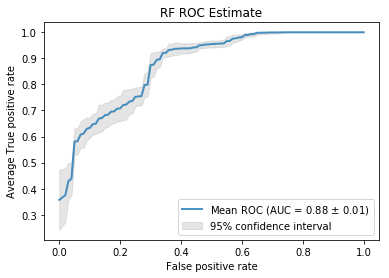

In [173]:
#function to plot ROC, pairs with cv_acc
def roc_plot(tpr_rf,AUCs):   
    from sklearn.metrics import auc
    mean_fpr = np.linspace(0,1,101);
    mean_tpr = np.mean(tpr_rf,axis = 0);
    std_tpr = np.std(tpr_rf,axis = 0);
    mean_auc = auc(mean_fpr,mean_tpr);
    std_auc = np.std(AUCs);

    plt.plot(mean_fpr, np.mean(tpr_rf,axis = 0),label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, 2.*std_auc),
                 lw=2, alpha=.8);
    tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'95% confidence interval')
    plt.xlabel('False positive rate')
    plt.ylabel('Average True positive rate');
    plt.title('ROC estimate');
    plt.legend(loc="lower right")
    

roc_plot(rf_tpr_rf,rf_AUCs) 
plt.title('RF ROC Estimate');
plt.savefig('rf_roc');

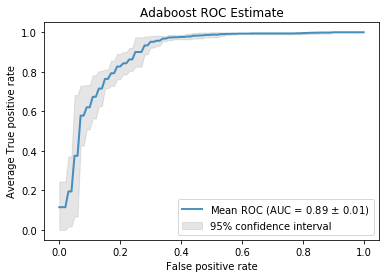

In [174]:
ada_acc,ada_sen,ada_spec,ada_AUCs,ada_tpr_rf= cv_acc(tuned_models[1],10,features,disease_state)
roc_plot(ada_tpr_rf,ada_AUCs) 
plt.title('Adaboost ROC Estimate');
plt.savefig('ada_roc');

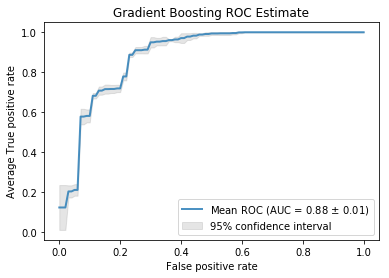

In [175]:
gbc_acc,gbc_sen,gbc_spec,gbc_AUCs,gbc_tpr_rf= cv_acc(tuned_models[2],10,features,disease_state)
roc_plot(gbc_tpr_rf,gbc_AUCs) 
plt.title('Gradient Boosting ROC Estimate');
plt.savefig('gbc_roc');

In [153]:
#functions to plot accuracy measures 
def plot_acc(accuracy,sensitivity,specificity):
    plt.bar(range(1,4),[np.mean(accuracy),np.mean(sensitivity),np.mean(specificity)],
            yerr = [np.std(accuracy),np.std(sensitivity),np.std(specificity)]);
    plt.xticks([1,2,3],['accuracy','sensitivity','specificity'],rotation = 0);
    plt.title('Accuracy measure of model on CV')
    



,accuracy,sensitivity,specificity
mean,0.853846,0.935374,0.604167
std,0.014368,0.007606,0.042696


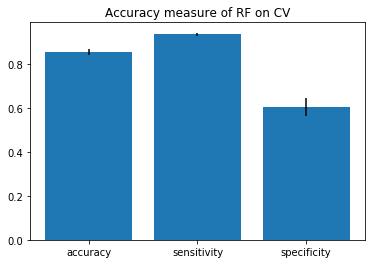

In [176]:
#plot and create a table for acc measures for all models
plot_acc(rf_acc,rf_sen,rf_spec);

plt.title('Accuracy measure of RF on CV')
plt.savefig('rf_acc.png')

stats = np.array([[np.mean(rf_acc),float(np.mean(rf_sen)),np.mean(rf_spec)],
                  [np.std(rf_acc),np.std(rf_sen),np.std(rf_spec)]]);
df = pd.DataFrame(stats,columns=(['accuracy','sensitivity','specificity']))
df.rename({0:'mean',1:'std'})


,accuracy,sensitivity,specificity
mean,0.892308,0.960544,0.683333
std,0.008581,0.007933,0.015590


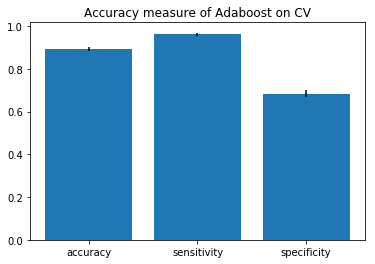

In [177]:
plot_acc(ada_acc,ada_sen,ada_spec);

plt.title('Accuracy measure of Adaboost on CV')
plt.savefig('ada_acc.png')

stats = np.array([[np.mean(ada_acc),float(np.mean(ada_sen)),np.mean(ada_spec)],
                  [np.std(ada_acc),np.std(ada_sen),np.std(ada_spec)]]);
df = pd.DataFrame(stats,columns=(['accuracy','sensitivity','specificity']))
df.rename({0:'mean',1:'std'})


,accuracy,sensitivity,specificity
mean,0.881538,0.940816,0.700000
std,0.006667,0.004356,0.016667


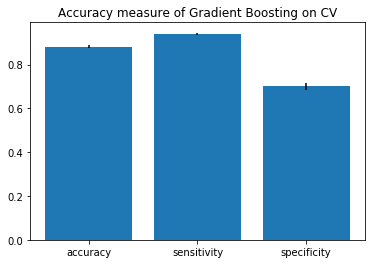

In [178]:
plot_acc(gbc_acc,gbc_sen,gbc_spec);

plt.title('Accuracy measure of Gradient Boosting on CV')
plt.savefig('gbc_acc.png')

stats = np.array([[np.mean(gbc_acc),float(np.mean(gbc_sen)),np.mean(gbc_spec)],
                  [np.std(gbc_acc),np.std(gbc_sen),np.std(gbc_spec)]]);
df = pd.DataFrame(stats,columns=(['accuracy','sensitivity','specificity']))
df.rename({0:'mean',1:'std'})



In [163]:
#function to calculate feature importance
def feat_imp(clf,features,disease_state):
    import sklearn as skl
    RANDOM_STATE = 347;

    diseased_idx = [i for  i,x in enumerate(disease_state) if x==1];
    nodisease_idx = [ i for i,x in enumerate(disease_state) if x==0];
    num_disease = len(diseased_idx);
    num_healthy = len(nodisease_idx);


    boot_featimp = [];
    num_boot = 100

    #perform a stratified bootstrap since the number of diseased is not about the same as number of healthy
    #(ie there are significantly more 1 labels than 0 labels)
    #stratification allows us to  keep the proportions of diseased and healthy similar to original dataset
    for boot in range(num_boot):
        indices = range(features.shape[0])
        resamp_disease = skl.utils.resample(diseased_idx,random_state = np.mod(RANDOM_STATE*(num_boot+71),593));
        resamp_nodisease = skl.utils.resample(nodisease_idx,random_state = np.mod(RANDOM_STATE*(num_boot+71),593));
        feat_resamp = np.concatenate((features[diseased_idx],features[nodisease_idx]),axis=0);
        states_resamp = np.concatenate((disease_state[diseased_idx],disease_state[nodisease_idx]),axis=0);

        clf.fit(feat_resamp,states_resamp);
        feat_imp = clf.feature_importances_
        boot_featimp.append(feat_imp);

    x = np.arange(22)
    plt.figure(figsize=(14,6))

    plt.bar(x,np.mean(boot_featimp,axis = 0),yerr = np.std(boot_featimp,axis = 0));
    plt.xticks(x,feature_names,rotation = 50);
    plt.title('Feature Importance')
    plt.savefig('featureImportance.png')


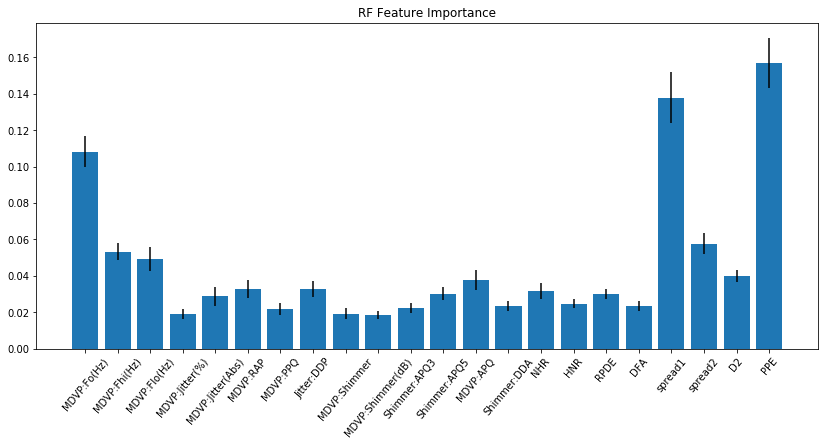

In [170]:
feat_imp(tuned_models[0],features,disease_state)
plt.title('RF Feature Importance');
plt.savefig('rf_feat_imp');

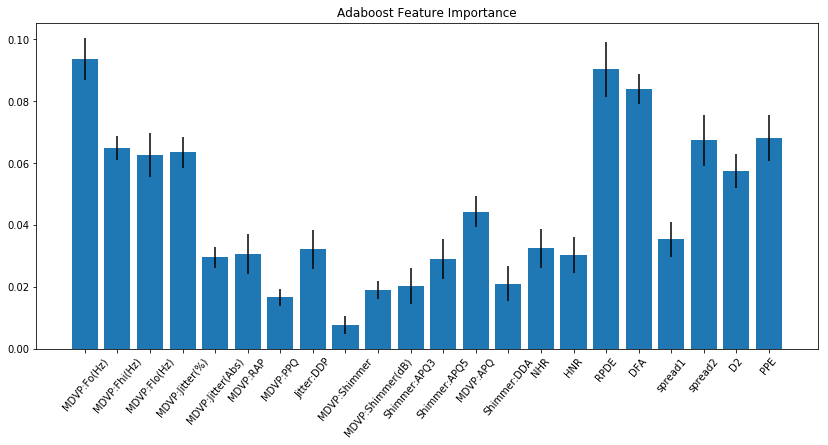

In [171]:
feat_imp(tuned_models[1],features,disease_state)
plt.title('Adaboost Feature Importance');
plt.savefig('ada_feat_imp');

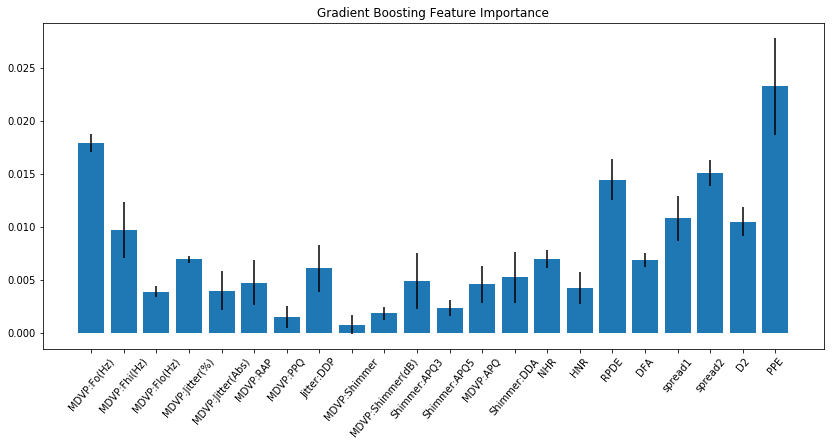

In [172]:
feat_imp(tuned_models[2],features,disease_state)
plt.title('Gradient Boosting Feature Importance');
plt.savefig('gbc_feat_imp');

In [179]:
#use Bayes Law to find posterior probabilities for parkinson's diagnosis
def post_prob(sensitivity,specificity):
    mean_sens = np.mean(sensitivity);
    mean_spec = np.mean(specificity);

    #estimate probability of having parkinsons
    p_parkinsons = 1e6/300e6

    sen_posterior = mean_sens*p_parkinsons/(mean_sens*p_parkinsons + (1-mean_spec)*(1-p_parkinsons));
    spec_posterior = mean_spec*(1-p_parkinsons)/(mean_spec*(1-p_parkinsons) + (1-mean_sens)*(p_parkinsons));

    print('The sensitivity posterior is ',sen_posterior,'\n'
          'The specificity posterior is ',spec_posterior);

In [180]:
post_prob(rf_sen,rf_spec)

The sensitivity posterior is  0.0078412084015 
The specificity posterior is  0.999642379026


In [181]:
post_prob(ada_sen,ada_spec)

The sensitivity posterior is  0.0100429242549 
The specificity posterior is  0.999806926351


In [182]:
post_prob(gbc_sen,gbc_spec)

The sensitivity posterior is  0.0103796100329 
The specificity posterior is  0.999717310354
